In [1]:
import project_path
import os
import numpy as np
import json
from tqdm import tqdm
from typing import List, Dict, Any, Union, Tuple
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import pandas as pd
import re

from attwizard.decoder import get_attention_representation
from attwizard.aligner import map_to_char_level
from attwizard.aligner import tokenize_char_level

from codeattention.source_code import SourceCode

from scipy.stats import spearmanr
from scipy.stats import kstest
from scipy.spatial.distance import jensenshannon

from attwizard.script.utils import read_data_in_parallel
from attwizard.script.utils import load_json_file

# EDA
from attwizard.visualizer.eda import visualize_corr_vs
from attwizard.visualizer.eda import visualize_code_heatmap_codegen
from attwizard.visualizer.eda import plot_histogram_in_parallel
from attwizard.visualizer.eda import plot_100_perc_stacked_bar

In [3]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
# Comparisons DATA
COMPARISON_FOLDER_CODEGEN = "../data/comparisons/cmp_v06/codegen_rebuttal"
COMPARISON_FOLDER_GPTJ = "../data/comparisons/cmp_v06/gptj_rebuttal"
COMPARISON_FOLDER_INCODER = "../data/comparisons/cmp_v06/incoder_rebuttal"
COMPARISON_VECTORS_FOLDERS = [COMPARISON_FOLDER_CODEGEN, COMPARISON_FOLDER_GPTJ, COMPARISON_FOLDER_INCODER]
COMPARISON_VECTORS_MODEL_NAMES = [
    "codegen",
    "gptj",
    "incoder"
]

# VISUAL COMPARISON CSVs
COMPARISON_NAMES = [
    'plain_weights_humans.csv', 
    'plain_weights_meanfollowers.csv', 
    'plain_weights_mean_meanfollowers.csv',
    'plain_weights_tokens_at_least_a_letter_humans.csv', 
    'plain_weights_tokens_at_least_a_letter_meanfollowers.csv', 
    'plain_weights_tokens_at_least_a_letter_mean_meanfollowers.csv']
OUT_PAPER_FOLDER = "../data/paper_figures/rebuttal"

# ANNOTATION - ACCURACY 
CODEGEN_ANNOTATIONS = "../data/annotations/2022-09-18/Answer Evaluation - Users - CODEGEN_SCORE.csv"
GPTJ_ANNOTATIONS = "../data/annotations/2022-09-18/Answer Evaluation - Users - GPTJ_SCORE.csv"
INCODER_ANNOTATIONS = "../data/annotations/2022-11-11/Answer Evaluation - Users - INCODER_SCORE.csv"
HUMAN_ANNOTATIONS = "../data/annotations/2022-09-18/Answer Evaluation - Users - HUMAN_SCORE.csv"

# Answer Correctness

In [5]:
df_codegen_score = pd.read_csv(CODEGEN_ANNOTATIONS)
df_human_score = pd.read_csv(HUMAN_ANNOTATIONS)
df_gptj_score = pd.read_csv(GPTJ_ANNOTATIONS)
df_incoder_score = pd.read_csv(INCODER_ANNOTATIONS)

# rename filename to unique_data_id
df_codegen_score = df_codegen_score.rename(columns={"filename": "unique_data_id"})
# extract the filename
# tree_Q3.py_0_Salesforce_codegen-16B-multi --> tree_Q3.py
df_codegen_score["filename"] = df_codegen_score["unique_data_id"].apply(
    lambda x: re.findall(r"(.*)_[0-9]+_Salesforce_codegen-[0-9]+", x)[0]
)
# rename column model_name --> provenance
# rename column n_try --> user
df_codegen_score = df_codegen_score.rename(columns={
    "model_name": "provenance",
    "n_try": "user"})
df_codegen_score["provenance"] = "CodeGen"

# rename filename to unique_data_id
df_gptj_score = df_gptj_score.rename(columns={"filename": "unique_data_id"})
df_gptj_score["filename"] = df_gptj_score["unique_data_id"].apply(
    lambda x: re.findall(r"(.*)_[0-9]+_EleutherAI_gpt-j-6B", x)[0]
)
# rename column model_name --> provenance
# rename column n_try --> user
df_gptj_score = df_gptj_score.rename(columns={
    "model_name": "provenance",
    "n_try": "user"})
df_gptj_score["provenance"] = "Gpt-j"

# rename filename to unique_data_id
df_incoder_score = df_incoder_score.rename(columns={"filename": "unique_data_id"})
df_incoder_score["filename"] = df_incoder_score["unique_data_id"].apply(
    lambda x: re.findall(r"(.*)_[0-9]+_facebook_incoder-6B+", x)[0]
)
# rename column model_name --> provenance
# rename column n_try --> user
df_incoder_score = df_incoder_score.rename(columns={
    "model_name": "provenance",
    "n_try": "user"})
df_incoder_score["provenance"] = "Incoder"


# keep columns: user, filename, score, unique_data_id
df_human_score = df_human_score[["user", "filename", "score", "unique_data_id"]]
# add provenance with human 
df_human_score["provenance"] = "Developers"

# concatenate the two dataframes
df_score = pd.concat([df_human_score, df_gptj_score, df_codegen_score, df_incoder_score], axis=0)
print(len(df_score))
replacement_dict = {
    0: "Wrong",
    1: "Partial",
    2: "Correct",
}
df_score["score"] = df_score["score"].replace(replacement_dict)
df_score.head()

497


,user,filename,score,unique_data_id,provenance
0,UbeerU,multithread_Q2.py,Wrong,d41dd8,Developers
1,UpassionU,hannoi_Q3.cs,Correct,6695fa,Developers
2,UcamelionU,hannoi_Q1.py,Correct,5403f5,Developers
3,UsleepU,hannoi_Q2.py,Correct,0d7601,Developers
4,UscoopU,triangle_Q3.cs,Partial,f936ca,Developers


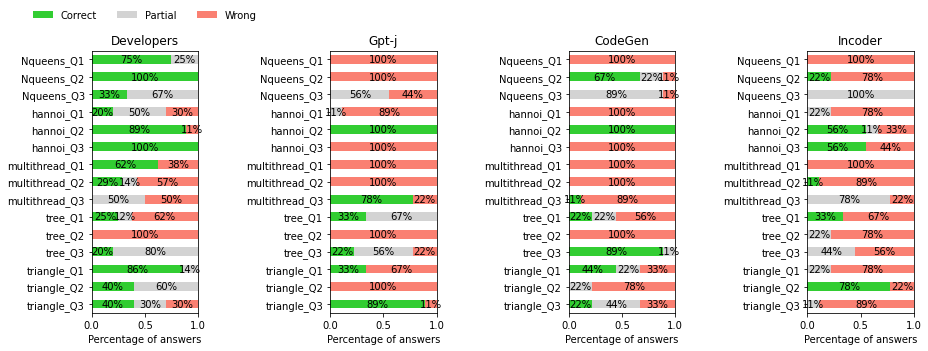

In [6]:
fig, axes = plt.subplots(1, 4, figsize=(13, 5))
for i, provenance in enumerate(["Developers", "Gpt-j", "CodeGen", "Incoder"]):
    df_tmp = df_score[df_score["provenance"] == provenance].copy()
    df_tmp["filename_pl_agnostic"] = df_tmp["filename"].apply(
        lambda x: x.split(".")[0])
    fig, ax = plot_100_perc_stacked_bar(
        df=df_tmp,
        col_name_group="filename_pl_agnostic",
        col_name_category_in_group="score",
        group_order=list(sorted(df_tmp["filename_pl_agnostic"].unique(), reverse=True)),
        direction="horizontal",
        convert_x_to_perc=False,
        color=["limegreen", "lightgrey", "salmon"],
        ax=axes[i],
    )
    ax.set_ylabel("")
    ax.set_title(provenance)
    ax.set_xlabel("Percentage of answers")
    ax.set_xlim(0, 1)
# remove legend 
axes[1].legend().remove()
axes[2].legend().remove()
axes[3].legend().remove()
axes[0].legend(
    bbox_to_anchor=(0.5, 1.1),
    loc="lower center",
    borderaxespad=0,
    frameon=False,
    ncol=3,
)

plt.tight_layout()
fig.savefig(os.path.join(OUT_PAPER_FOLDER, "RQ1_correctness_per_task.pdf"), bbox_inches="tight")

/home/eaftan/copilot-attention/attwizard/visualizer/eda.py:276: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(


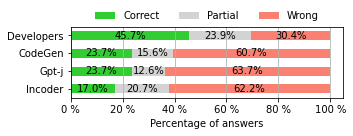

In [7]:
fig, ax = plot_100_perc_stacked_bar(
    df=df_score,
    col_name_group="provenance",
    col_name_category_in_group="score",
    group_order=["Incoder", "Gpt-j", "CodeGen", "Developers"],
    direction="horizontal",
    color=["limegreen", "lightgrey", "salmon"],
    fmt="{:.1%}"
)
# change size 
fig.set_size_inches(5, 2)
# remove ylabel
ax.set_ylabel("")
ax.set_xlabel("Percentage of answers")
plt.tight_layout()

plt.savefig(os.path.join(OUT_PAPER_FOLDER, "RQ1_correctness.pdf"))

# Dataset Stats

language,filename_pl_agnostic,cpp,cs,py
0,Nqueens_Q1,0.0,3.0,1.0
1,Nqueens_Q2,1.0,0.0,0.0
2,Nqueens_Q3,2.0,1.0,0.0
3,hannoi_Q1,3.0,4.0,3.0
4,hannoi_Q2,1.0,4.0,4.0


Percentage of C++ answers: 17.4%
\newcommand{\datasetPercCpp}{17.4\%}
\newcommand{\datasetPercCs}{43.5\%}
\newcommand{\datasetPercPy}{39.1\%}


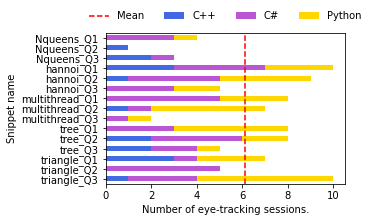

In [16]:
fig, ax =  plt.subplots(1, 1, figsize=(5, 3.2))
df_tmp = df_score[df_score["provenance"] == "Developers"].copy()
df_tmp["filename_pl_agnostic"] = df_tmp["filename"].apply(
    lambda x: x.split(".")[0])
df_tmp["language"] = df_tmp["filename"].apply(
    lambda x: x.split(".")[1])

# pivot table to have one column per language and one row per filename
# the value is the counting of each filename with the corresponding language
df_tmp = df_tmp.pivot_table(
    index="filename_pl_agnostic",
    columns="language",
    values="score",
    aggfunc="count",
)
# fill NaN with 0
df_tmp = df_tmp.fillna(0)
df_tmp.reset_index(inplace=True)
display(df_tmp.head())

# create stacked bar plot
# sort index alphabetically
df_tmp.set_index("filename_pl_agnostic", inplace=True)
df_tmp = df_tmp.reindex(sorted(df_tmp.index, reverse=True), axis=0)
df_tmp.plot(
    kind='barh',
    stacked=True,
    color=["royalblue", "mediumorchid", "gold"],
    ax=ax,
)
# plot a red line to indicate the mean of the number of answers per snippet
# sum the columns to get the number of answers per snippet
df_tmp["total"] = df_tmp["cpp"] + df_tmp["cs"] + df_tmp["py"]
mean = df_tmp["total"].mean()
ax.axvline(mean, color="red", linestyle="--")
# add mean to the legend
ax.legend(
    bbox_to_anchor=(0.5, 1.05),
    loc="lower center",
    borderaxespad=0,
    frameon=False,
    ncol=4,
    labels=["Mean", "C++", "C#", "Python"],
)

plt.xlabel("Number of eye-tracking sessions.")
plt.ylabel("Snippet name")
plt.tight_layout()
plt.savefig(os.path.join(OUT_PAPER_FOLDER, "dataset_stats.pdf"))

# compute the percentage of answers per language
total_cpp_answers = df_tmp["cpp"].sum()
total_cs_answers = df_tmp["cs"].sum()
total_py_answers = df_tmp["py"].sum()
total_answers = total_cpp_answers + total_cs_answers + total_py_answers
perc_cpp_answers = (total_cpp_answers / total_answers) * 100
print("\\newcommand{\\datasetPercCpp}{" + f"{perc_cpp_answers:.1f}" + "\\%}")
perc_cs_answers = (total_cs_answers / total_answers) * 100
print("\\newcommand{\\datasetPercCs}{" + f"{perc_cs_answers:.1f}" + "\\%}")
perc_py_answers = (total_py_answers / total_answers) * 100
print("\\newcommand{\\datasetPercPy}{" + f"{perc_py_answers:.1f}" + "\\%}")


# CodeGen

In [17]:
# LOAD COMPARISON DATA

dict_df_comparison_vectors = {}

for model_name, comparison_folder in zip(COMPARISON_VECTORS_MODEL_NAMES, COMPARISON_VECTORS_FOLDERS):
    print("Loading comparison vectors for model ", model_name)
    dfs = []
    for comparison in tqdm(COMPARISON_NAMES):
        df = pd.read_csv(os.path.join(comparison_folder, comparison))
        dfs.append(df)
    df_vectors = pd.concat(dfs)
    print("Loaded: ", df_vectors["comparison_name"].unique())
    df_vectors["model_name"] = model_name
    dict_df_comparison_vectors[model_name] = df_vectors

Loading comparison vectors for model  codegen


100%|██████████| 6/6 [00:07<00:00,  1.25s/it]


Loaded:  ['plain_weights_humans' 'plain_weights_meanfollowers'
 'plain_weights_mean_meanfollowers'
 'plain_weights_tokens_at_least_a_letter_humans'
 'plain_weights_tokens_at_least_a_letter_meanfollowers'
 'plain_weights_tokens_at_least_a_letter_mean_meanfollowers']
Loading comparison vectors for model  gptj


100%|██████████| 6/6 [00:02<00:00,  3.00it/s]


Loaded:  ['plain_weights_humans' 'plain_weights_meanfollowers'
 'plain_weights_mean_meanfollowers'
 'plain_weights_tokens_at_least_a_letter_humans'
 'plain_weights_tokens_at_least_a_letter_meanfollowers'
 'plain_weights_tokens_at_least_a_letter_mean_meanfollowers']
Loading comparison vectors for model  incoder


100%|██████████| 6/6 [00:01<00:00,  4.48it/s]

Loaded:  ['plain_weights_humans' 'plain_weights_meanfollowers'
 'plain_weights_mean_meanfollowers'
 'plain_weights_tokens_at_least_a_letter_humans'
 'plain_weights_tokens_at_least_a_letter_meanfollowers'
 'plain_weights_tokens_at_least_a_letter_mean_meanfollowers']


In [18]:
df_codegen_vectors = dict_df_comparison_vectors["codegen"]
df_gptj_vectors = dict_df_comparison_vectors["gptj"]
df_incoder_vectors = dict_df_comparison_vectors["incoder"]

vector_comparisons_chars = [
    {
        "long": "Developers vs Model (CodeGen) - Max",
        'data': df_codegen_vectors[df_codegen_vectors["comparison_name"] == "plain_weights_meanfollowers"],
        'color': 'lightblue'
    },
    {
        "long": "Developers vs Model (Gpt-j) - Max",
        'data': df_gptj_vectors[df_gptj_vectors["comparison_name"] == "plain_weights_meanfollowers"],
        'color': 'lightblue'
    },
    {
        "long": "Developers vs Model (InCoder) - Max",
        'data': df_incoder_vectors[df_incoder_vectors["comparison_name"] == "plain_weights_meanfollowers"],
        'color': 'lightblue'
    },
    {
        "long": "Developers vs Developers ",
        "data": df_gptj_vectors[df_gptj_vectors["comparison_name"] == "plain_weights_humans"],
        'color': 'lime'
    },
]

vector_comparisons_programming_languages = []

dict_language_to_color = {
    "py": "gold",
    "cs": "mediumorchid",
    "cpp": "royalblue"
}

for df, model_name in zip([df_codegen_vectors, df_gptj_vectors, df_incoder_vectors], ["codegen", "gptj", "incoder"]):
    for lang in ["py", "cs", "cpp"]:
        vector_comparisons_programming_languages.append({
            "long": f"Devs vs {model_name.capitalize()} - {lang.upper()}",
            "data": df[(
                (df["comparison_name"] == "plain_weights_meanfollowers") &
                (df["source_code"].str.endswith(f".{lang}"))
            )],
            'color': dict_language_to_color[lang]
        })


(<Figure size 360x354.24 with 4 Axes>,
 array([[<AxesSubplot:xlabel='Spearman Rank Corr. Developers vs Model (CodeGen) - Max', ylabel='Count'>],
        [<AxesSubplot:xlabel='Spearman Rank Corr. Developers vs Model (Gpt-j) - Max', ylabel='Count'>],
        [<AxesSubplot:xlabel='Spearman Rank Corr. Developers vs Model (InCoder) - Max', ylabel='Count'>],
        [<AxesSubplot:xlabel='Spearman Rank Corr. Developers vs Developers ', ylabel='Count'>]],
       dtype=object))

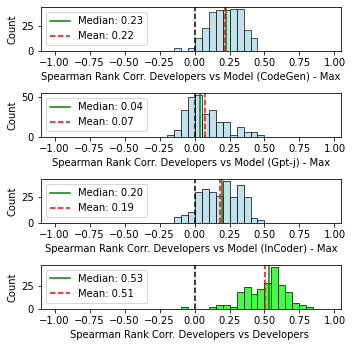

In [19]:
plot_histogram_in_parallel(
    vector_comparisons_chars,
    col_name="correlation",
    common_prefix="Spearman Rank Corr.",
    bins=np.arange(-1, 1, 0.05),
    vertical_zero_line=True, 
    out_path=os.path.join(OUT_PAPER_FOLDER, "human_vs_models_vector_agreement_chars.pdf"),
)

In [20]:
for info in vector_comparisons_programming_languages:
    print(info["long"])

Devs vs Codegen - PY
Devs vs Codegen - CS
Devs vs Codegen - CPP
Devs vs Gptj - PY
Devs vs Gptj - CS
Devs vs Gptj - CPP
Devs vs Incoder - PY
Devs vs Incoder - CS
Devs vs Incoder - CPP


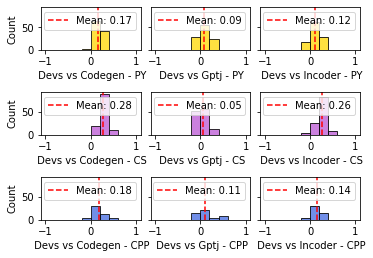

In [21]:
fig, axes = plot_histogram_in_parallel(
    vector_comparisons_programming_languages,
    col_name="correlation",
    common_prefix="",
    bins=np.arange(-1, 1.1, 0.2),
    n_cols=3,
    sharey=True,
    filling_direction="vertical",
    show_mean=True,
    show_median=False,
    width=5.2,
    vertical_zero_line=False, 
)
plt.tight_layout()
# reduce space between subplots
plt.subplots_adjust(wspace=0.1)
plt.savefig(os.path.join(OUT_PAPER_FOLDER, "human_vs_model_pl_agreement.pdf"))

In [22]:
# run the mann-whitney test for all the programming languages pairs (e.g. cpp vs cs, cpp vs py, cs vs py)
from scipy.stats import mannwhitneyu

records = []

for lang1, lang2 in zip(["cpp", "cpp", "cs"], ["cs", "py", "py"]):
    print(f"Comparing {lang1} vs {lang2}")
    for df, model_name in zip([df_codegen_vectors, df_gptj_vectors, df_incoder_vectors], ["codegen", "gptj", "incoder"]):
        df1 = df[(
            (df["comparison_name"] == "plain_weights_meanfollowers") &
            (df["source_code"].str.endswith(f".{lang1}"))
        )]
        df2 = df[(
            (df["comparison_name"] == "plain_weights_meanfollowers") &
            (df["source_code"].str.endswith(f".{lang2}"))
        )]
        stat, p = mannwhitneyu(df1["correlation"], df2["correlation"])
        is_reject = p < 0.05
        # print "different distribution (reject H0)" if p-value is lower than 0.05
        print(f"{model_name}: {stat} {p}", end=" --> ")
        if is_reject:
            print("different distribution (reject H0)")
        else:
            print("same distribution (fail to reject H0)")

        records.append({
            'Model': model_name.capitalize(),
            'Lang-A': lang1,
            'Lang-B': lang2,
            'Stat.': stat,
            'pval': p,
            'Result': 'Same' if p > 0.05 else 'Diff.'
        })

df_latex_table = pd.DataFrame.from_records(records)
# format the p-value column with 2 decimals and scientific notation
df_latex_table["pval"] = df_latex_table["pval"].apply(lambda x: f'{x:.2e}')
# print leatx code
print(df_latex_table.to_latex(index=False))

Comparing cpp vs cs
codegen: 1486.0 9.948907738247046e-07 --> different distribution (reject H0)
gptj: 3404.0 0.06605019930807757 --> same distribution (fail to reject H0)
incoder: 1280.0 1.9551640375091315e-08 --> different distribution (reject H0)
Comparing cpp vs py
codegen: 2685.0 0.7224517067590843 --> same distribution (fail to reject H0)
gptj: 2571.0 0.9372562670299786 --> same distribution (fail to reject H0)
incoder: 2947.0 0.17344554120505173 --> same distribution (fail to reject H0)
Comparing cs vs py
codegen: 10334.0 9.285988899858277e-15 --> different distribution (reject H0)
gptj: 5323.0 0.020043541087858767 --> different distribution (reject H0)
incoder: 10327.0 1.0374442131134318e-14 --> different distribution (reject H0)
\begin{tabular}{lllrll}
\toprule
  Model & Lang-A & Lang-B &   Stat. &     pval & Result \\
\midrule
Codegen &    cpp &     cs &  1486.0 & 9.95e-07 &  Diff. \\
   Gptj &    cpp &     cs &  3404.0 & 6.61e-02 &   Same \\
Incoder &    cpp &     cs &  1280

/tmp/ipykernel_3338088/2276344442.py:39: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df_latex_table.to_latex(index=False))


In [23]:
df_score["provenance"].unique()

array(['Developers', 'Gpt-j', 'CodeGen', 'Incoder'], dtype=object)

['CodeGen - cpp',
 'CodeGen - cs',
 'CodeGen - py',
 'Developers - cpp',
 'Developers - cs',
 'Developers - py',
 'Gpt-j - cpp',
 'Gpt-j - cs',
 'Gpt-j - py',
 'Incoder - cpp',
 'Incoder - cs',
 'Incoder - py']

/home/eaftan/copilot-attention/attwizard/visualizer/eda.py:276: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(


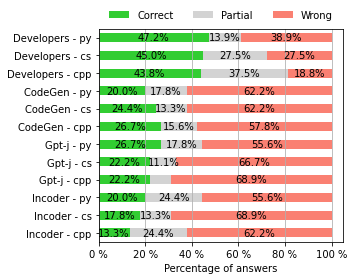

In [33]:
df = df_score
# generate a new column with the programming language and the provenace
df['language'] = df['filename'].str.split('.').str[-1]
df['language_and_provenance'] = df['provenance'] + " - " + df['language']
# get unique values of the new column sorted by provenance, putting developers first
language_and_provenance_values = list(sorted(df['language_and_provenance'].unique()))
display(language_and_provenance_values)

# plot how many answers are: Correct, Wrong, Partial 
# for each programming language
# the column score can be: ["Correct", "Wrong", "Partial"]
fig, ax = plot_100_perc_stacked_bar(
    df=df,
    col_name_group="language_and_provenance",
    col_name_category_in_group="score",
    group_order=[
        'Incoder - cpp',
        'Incoder - cs',
        'Incoder - py',
        'Gpt-j - cpp',
        'Gpt-j - cs',
        'Gpt-j - py',
        'CodeGen - cpp',
        'CodeGen - cs',
        'CodeGen - py',        
        'Developers - cpp',
        'Developers - cs',
        'Developers - py',],
    direction="horizontal",
    color=["limegreen", "lightgrey", "salmon"],
    fmt="{:.1%}"
)
# change size 
fig.set_size_inches(5, 4)
# remove ylabel
ax.set_ylabel("")
ax.set_xlabel("Percentage of answers")
plt.tight_layout()
plt.savefig(os.path.join(OUT_PAPER_FOLDER, f"correctness_per_PL_ALL.pdf"))
plt.show()

/tmp/ipykernel_3324438/489859215.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['language'] = df['filename'].str.split('.').str[-1]
/home/eaftan/copilot-attention/attwizard/visualizer/eda.py:276: UserWarning: FixedFormatter should only be used together with FixedLocator
  [f"{int(x * 100)} %" for x in ax.get_xticks()],


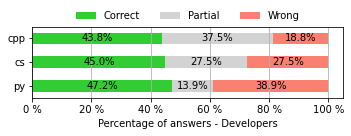

/tmp/ipykernel_3324438/489859215.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['language'] = df['filename'].str.split('.').str[-1]
/home/eaftan/copilot-attention/attwizard/visualizer/eda.py:276: UserWarning: FixedFormatter should only be used together with FixedLocator
  [f"{int(x * 100)} %" for x in ax.get_xticks()],


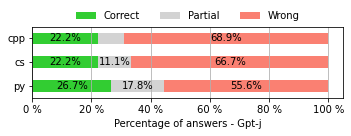

/tmp/ipykernel_3324438/489859215.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['language'] = df['filename'].str.split('.').str[-1]
/home/eaftan/copilot-attention/attwizard/visualizer/eda.py:276: UserWarning: FixedFormatter should only be used together with FixedLocator
  [f"{int(x * 100)} %" for x in ax.get_xticks()],


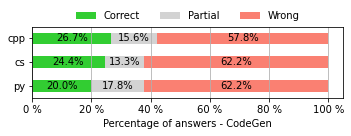

/tmp/ipykernel_3324438/489859215.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['language'] = df['filename'].str.split('.').str[-1]
/home/eaftan/copilot-attention/attwizard/visualizer/eda.py:276: UserWarning: FixedFormatter should only be used together with FixedLocator
  [f"{int(x * 100)} %" for x in ax.get_xticks()],


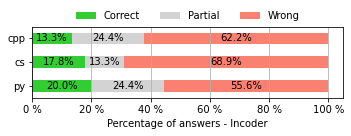

In [144]:
for i_provenance in ['Developers', 'Gpt-j', 'CodeGen', 'Incoder']:

    # compute average score of developer for each programming language
    # consider only human data
    df = df_score[df_score["provenance"] == i_provenance]
    df['language'] = df['filename'].str.split('.').str[-1]
    # plot how many answers are: Correct, Wrong, Partial 
    # for each programming language
    # the column score can be: ["Correct", "Wrong", "Partial"]
    fig, ax = plot_100_perc_stacked_bar(
        df=df,
        col_name_group="language",
        col_name_category_in_group="score",
        group_order=["py", "cs", "cpp"],
        direction="horizontal",
        color=["limegreen", "lightgrey", "salmon"],
        fmt="{:.1%}"
    )
    # change size 
    fig.set_size_inches(5, 2)
    # remove ylabel
    ax.set_ylabel("")
    ax.set_xlabel("Percentage of answers - " + i_provenance)
    plt.tight_layout()
    plt.savefig(os.path.join(OUT_PAPER_FOLDER, f"correctness_per_PL_{i_provenance}.pdf"))
    plt.show()

# Performance vs Agreement


In [108]:
df_all_vectors = pd.concat([df_codegen_vectors, df_gptj_vectors, df_incoder_vectors])
# keep only the data for the comparison "plain_weights_meanfollowers"
df_all_vectors = df_all_vectors[
    df_all_vectors["comparison_name"] == "plain_weights_meanfollowers"]
# rename input_machine_filestem to filename
df_all_vectors = df_all_vectors.rename(
    columns={"input_machine_filestem": "unique_data_id"})

In [109]:
df_all_vectors.head()

,comparison_name,comparison_function,source_code,user_name_a,task_number_a,user_name_b,task_number_b,human_a,human_b,comparison_type,...,user_name,task_number,input_human_filestem,unique_data_id,transformation_0.name,transformation_0.kwargs.mapping_from_token_to_char,transformation_1.name,machine_att_folder,model_name,transformation_0.kwargs.drop_first_token
0,plain_weights_meanfollowers,spearman_rank,hannoi_Q1.cs,NaN,NaN,NaN,NaN,NaN,NaN,vector,...,UsurfU,0.0,f4bbec,hannoi_Q1.cs_2_Salesforce_codegen-16B-multi,convert_to_char_level,equal_share,convert_vect_to_probabilities,./data/model_output/exp_v10/codegen,codegen,NaN
1,plain_weights_meanfollowers,spearman_rank,hannoi_Q1.cs,NaN,NaN,NaN,NaN,NaN,NaN,vector,...,UsurfU,0.0,f4bbec,hannoi_Q1.cs_1_Salesforce_codegen-16B-multi,convert_to_char_level,equal_share,convert_vect_to_probabilities,./data/model_output/exp_v10/codegen,codegen,NaN
2,plain_weights_meanfollowers,spearman_rank,hannoi_Q1.cs,NaN,NaN,NaN,NaN,NaN,NaN,vector,...,UsurfU,0.0,f4bbec,hannoi_Q1.cs_0_Salesforce_codegen-16B-multi,convert_to_char_level,equal_share,convert_vect_to_probabilities,./data/model_output/exp_v10/codegen,codegen,NaN
3,plain_weights_meanfollowers,spearman_rank,multithread_Q2.py,NaN,NaN,NaN,NaN,NaN,NaN,vector,...,UbeerU,3.0,d41dd8,multithread_Q2.py_2_Salesforce_codegen-16B-multi,convert_to_char_level,equal_share,convert_vect_to_probabilities,./data/model_output/exp_v10/codegen,codegen,NaN
4,plain_weights_meanfollowers,spearman_rank,multithread_Q2.py,NaN,NaN,NaN,NaN,NaN,NaN,vector,...,UbeerU,3.0,d41dd8,multithread_Q2.py_1_Salesforce_codegen-16B-multi,convert_to_char_level,equal_share,convert_vect_to_probabilities,./data/model_output/exp_v10/codegen,codegen,NaN


In [110]:
df_score

,user,filename,score,unique_data_id,provenance
0,UbeerU,multithread_Q2.py,Wrong,d41dd8,Developers
1,UpassionU,hannoi_Q3.cs,Correct,6695fa,Developers
2,UcamelionU,hannoi_Q1.py,Correct,5403f5,Developers
3,UsleepU,hannoi_Q2.py,Correct,0d7601,Developers
4,UscoopU,triangle_Q3.cs,Partial,f936ca,Developers
...,...,...,...,...,...
130,1,Nqueens_Q1.cs,Wrong,Nqueens_Q1.cs_1_facebook_incoder-6B,Incoder
131,0,Nqueens_Q1.cs,Wrong,Nqueens_Q1.cs_0_facebook_incoder-6B,Incoder
132,2,Nqueens_Q1.cpp,Wrong,Nqueens_Q1.cpp_2_facebook_incoder-6B,Incoder
133,1,Nqueens_Q1.cpp,Wrong,Nqueens_Q1.cpp_1_facebook_incoder-6B,Incoder


In [112]:
len_before = len(df_all_vectors)

# merge the dataframes df_all_vectors and df_score
# on the column filename
df_merged = pd.merge(
    df_all_vectors,
    df_score,
    on="unique_data_id"
)

len_after = len(df_merged)
print(f"Number of rows before merge: {len_before}")
print(f"Number of rows after merge: {len_after}")

Number of rows before merge: 828
Number of rows after merge: 828


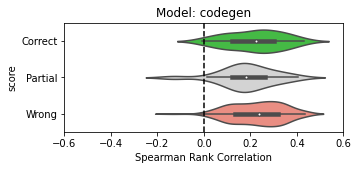

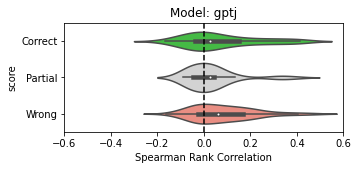

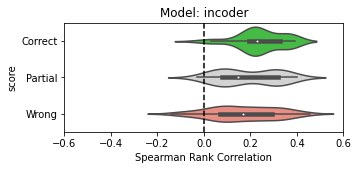

In [134]:
for model_name in ["codegen", "gptj", "incoder"]:
    df = df_merged[df_merged["model_name"] == model_name]
    # sort by score
    df = df.sort_values(by="score")
    fig, ax = plt.subplots(figsize=(5, 2))
    sns.violinplot(
        data=df,
        y="score",
        x="correlation",
        #hue="score",
        #order=["Correct", "Partial", "Wrong"],
        palette=["limegreen", "lightgrey", "salmon"],
        meanline=True,
        showmeans=True,
        ax=ax
    )
    ax.set_xlim(-.6, .6)
    # vertical line at 0
    ax.axvline(x=0, color="black", linestyle="--")
    ax.set_xlabel("Spearman Rank Correlation")
    ax.set_title(f"Model: {model_name}")
    plt.show()
        

In [64]:
df_corr = DF_CODEGEN[DF_CODEGEN["comparison_name"].isin(["plain_weights_meanfollowers"])]
df_corr.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 276 entries, 0 to 275
Data columns (total 35 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   comparison_name                                     276 non-null    object 
 1   comparison_function                                 276 non-null    object 
 2   source_code                                         276 non-null    object 
 3   user_name_a                                         0 non-null      object 
 4   task_number_a                                       0 non-null      float64
 5   user_name_b                                         0 non-null      object 
 6   task_number_b                                       0 non-null      float64
 7   human_a                                             0 non-null      object 
 8   human_b                                             0 non-null      object 
 9  

In [65]:
# rename input_machine_filestem to filename
df_corr = df_corr.rename(columns={"input_machine_filestem": "filename"})

In [66]:
df_corr.head()

,comparison_name,comparison_function,source_code,user_name_a,task_number_a,user_name_b,task_number_b,human_a,human_b,comparison_type,...,human_att_folder,user_name,task_number,input_human_filestem,filename,transformation_0.name,transformation_0.kwargs.mapping_from_token_to_char,transformation_1.name,machine_att_folder,programming_language
0,plain_weights_meanfollowers,spearman_rank,tree_Q2.py,NaN,NaN,NaN,NaN,NaN,NaN,vector,...,./data/eye_tracking_attention/eye_v10,UbagU,2.0,0480e5,tree_Q2.py_0_Salesforce_codegen-16B-multi,convert_to_char_level,equal_share,convert_vect_to_probabilities,./data/model_output/exp_v10/codegen,py
1,plain_weights_meanfollowers,spearman_rank,tree_Q2.py,NaN,NaN,NaN,NaN,NaN,NaN,vector,...,./data/eye_tracking_attention/eye_v10,UbagU,2.0,0480e5,tree_Q2.py_1_Salesforce_codegen-16B-multi,convert_to_char_level,equal_share,convert_vect_to_probabilities,./data/model_output/exp_v10/codegen,py
2,plain_weights_meanfollowers,spearman_rank,tree_Q2.py,NaN,NaN,NaN,NaN,NaN,NaN,vector,...,./data/eye_tracking_attention/eye_v10,UbagU,2.0,0480e5,tree_Q2.py_2_Salesforce_codegen-16B-multi,convert_to_char_level,equal_share,convert_vect_to_probabilities,./data/model_output/exp_v10/codegen,py
3,plain_weights_meanfollowers,spearman_rank,triangle_Q3.py,NaN,NaN,NaN,NaN,NaN,NaN,vector,...,./data/eye_tracking_attention/eye_v10,UbeerU,2.0,08147e,triangle_Q3.py_0_Salesforce_codegen-16B-multi,convert_to_char_level,equal_share,convert_vect_to_probabilities,./data/model_output/exp_v10/codegen,py
4,plain_weights_meanfollowers,spearman_rank,triangle_Q3.py,NaN,NaN,NaN,NaN,NaN,NaN,vector,...,./data/eye_tracking_attention/eye_v10,UbeerU,2.0,08147e,triangle_Q3.py_1_Salesforce_codegen-16B-multi,convert_to_char_level,equal_share,convert_vect_to_probabilities,./data/model_output/exp_v10/codegen,py


In [67]:
df_codegen_score = pd.read_csv(CODEGEN_ANNOTATIONS)
df_codegen_score.head()


,filename,model_name,n_try,score
0,tree_Q3.py_0_Salesforce_codegen-16B-multi,codegen-16B-multi,0,2
1,triangle_Q3.py_1_Salesforce_codegen-16B-multi,codegen-16B-multi,1,0
2,multithread_Q1.cpp_1_Salesforce_codegen-16B-multi,codegen-16B-multi,1,0
3,triangle_Q1.cs_1_Salesforce_codegen-16B-multi,codegen-16B-multi,1,2
4,hannoi_Q2.cpp_1_Salesforce_codegen-16B-multi,codegen-16B-multi,1,2


In [68]:
df_score_and_corr = pd.merge(
   left=df_corr,
   right=df_codegen_score,
   on='filename', 
)
df_score_and_corr.head()

,comparison_name,comparison_function,source_code,user_name_a,task_number_a,user_name_b,task_number_b,human_a,human_b,comparison_type,...,input_human_filestem,filename,transformation_0.name,transformation_0.kwargs.mapping_from_token_to_char,transformation_1.name,machine_att_folder,programming_language,model_name,n_try,score
0,plain_weights_meanfollowers,spearman_rank,tree_Q2.py,NaN,NaN,NaN,NaN,NaN,NaN,vector,...,0480e5,tree_Q2.py_0_Salesforce_codegen-16B-multi,convert_to_char_level,equal_share,convert_vect_to_probabilities,./data/model_output/exp_v10/codegen,py,codegen-16B-multi,0,0
1,plain_weights_meanfollowers,spearman_rank,tree_Q2.py,NaN,NaN,NaN,NaN,NaN,NaN,vector,...,5a70af,tree_Q2.py_0_Salesforce_codegen-16B-multi,convert_to_char_level,equal_share,convert_vect_to_probabilities,./data/model_output/exp_v10/codegen,py,codegen-16B-multi,0,0
2,plain_weights_meanfollowers,spearman_rank,tree_Q2.py,NaN,NaN,NaN,NaN,NaN,NaN,vector,...,0480e5,tree_Q2.py_1_Salesforce_codegen-16B-multi,convert_to_char_level,equal_share,convert_vect_to_probabilities,./data/model_output/exp_v10/codegen,py,codegen-16B-multi,1,0
3,plain_weights_meanfollowers,spearman_rank,tree_Q2.py,NaN,NaN,NaN,NaN,NaN,NaN,vector,...,5a70af,tree_Q2.py_1_Salesforce_codegen-16B-multi,convert_to_char_level,equal_share,convert_vect_to_probabilities,./data/model_output/exp_v10/codegen,py,codegen-16B-multi,1,0
4,plain_weights_meanfollowers,spearman_rank,tree_Q2.py,NaN,NaN,NaN,NaN,NaN,NaN,vector,...,0480e5,tree_Q2.py_2_Salesforce_codegen-16B-multi,convert_to_char_level,equal_share,convert_vect_to_probabilities,./data/model_output/exp_v10/codegen,py,codegen-16B-multi,2,0


<AxesSubplot:xlabel='score', ylabel='correlation'>

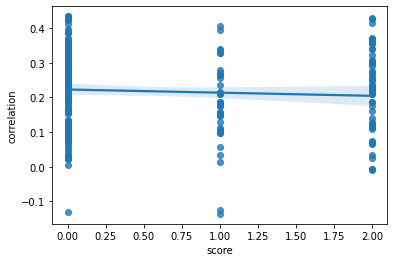

In [70]:
sns.regplot(
    data=df_score_and_corr,
    x="score",
    y="correlation",
)

# PL Study

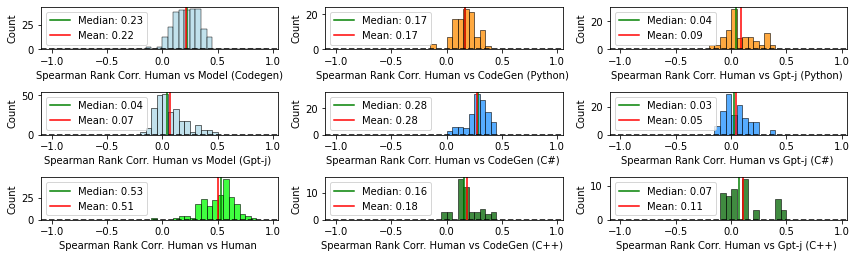

In [38]:
PL_LONG_NAMES = ["Python", "C#", "C++"]
pl_comparisons = [
    c
    for c in vector_comparisons_codegen + vector_comparisons_gptj
    if any([l in c["long"] for l in PL_LONG_NAMES])
]
all_comparisons = vector_comparisons_codegen[:1] + vector_comparisons_gptj[:2] + pl_comparisons
plot_histogram_in_parallel(
    all_comparisons,
    col_name="correlation",
    common_prefix="Spearman Rank Corr.",
    bins=np.arange(-1, 1, 0.05),
    n_cols=3,
    filling_direction="vertical",
    width=12,
    vertical_zero_line=True, 
    out_path=os.path.join(OUT_PAPER_FOLDER, "human_vs_model_agreement_all_and_pl.pdf"),
)

# Mann Whitney U test

In [35]:
# Example of the Mann-Whitney U Test 
from scipy.stats import mannwhitneyu 
PAIRS = [
    ['py', 'cpp'],
    ['py', 'cs'],
    ['cpp', 'cs'],
]
records = []
for lang_a, lang_b in PAIRS: 
    print(f'Comparing {lang_a} vs {lang_b}')
    for df, name in [
            (df_human_vs_model_gptj_same_question_res, 'Gpt-j'),
            (df_human_vs_model_codegen_same_question_res, 'Codegen'),]:
        print(f'\tDataset Model:  {name}')
        data_a = df[df["programming_language"] == lang_a]["correlation"] 
        data_b = df[df["programming_language"] == lang_b]["correlation"] 
        stat, p = mannwhitneyu(data_a, data_b) 
        # scientific notation with 2 decimals
        print(f'\tstat={stat:.3f}, p={p:.2e}') 
        if p > 0.05: 
            print('\tProbably the same distribution') 
        else: 
            print('\tProbably different distributions')
        records.append({
            'Neural Model': name,
            'Lang. A': lang_a,
            'Lang. B': lang_b,
            'Statistic': stat,
            'p-value': p,
            'Result': 'Probably same distrib.' if p > 0.05 else 'Probably diff. distrib.'
        })

df_latex_table = pd.DataFrame.from_records(records)
# format the p-value column with 2 decimals and scientific notation
df_latex_table["p-value"] = df_latex_table["p-value"].apply(lambda x: f'{x:.2e}')
# print leatx code
print(df_latex_table.to_latex(index=False))

Comparing py vs cpp
	Dataset Model:  Gpt-j
	stat=2613.000, p=9.37e-01
	Probably the same distribution
	Dataset Model:  Codegen
	stat=2499.000, p=7.22e-01
	Probably the same distribution
Comparing py vs cs
	Dataset Model:  Gpt-j
	stat=7637.000, p=2.00e-02
	Probably different distributions
	Dataset Model:  Codegen
	stat=2626.000, p=9.29e-15
	Probably different distributions
Comparing cpp vs cs
	Dataset Model:  Gpt-j
	stat=3404.000, p=6.61e-02
	Probably the same distribution
	Dataset Model:  Codegen
	stat=1486.000, p=9.95e-07
	Probably different distributions
\begin{tabular}{lllrll}
\toprule
Neural Model & Lang. A & Lang. B &  Statistic &  p-value &                  Result \\
\midrule
       Gpt-j &      py &     cpp &     2613.0 & 9.37e-01 &  Probably same distrib. \\
     Codegen &      py &     cpp &     2499.0 & 7.22e-01 &  Probably same distrib. \\
       Gpt-j &      py &      cs &     7637.0 & 2.00e-02 & Probably diff. distrib. \\
     Codegen &      py &      cs &     2626.0 & 9.2

/tmp/ipykernel_2651969/3116067965.py:37: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df_latex_table.to_latex(index=False))


# Sampling

In [7]:
# GOAL: we want to see how much the agreemnent changes in groups where we only 
# comparisons on tasks with the same programming language (PL) vs groups of 
# comparisons on randomly picked tasks (even of different PLs).
N_TASKS_PER_GROUP = 100
N_REPETITIONS = 30
df = df_human_vs_model_codegen_same_question_res

len(df)

276

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 276 entries, 0 to 275
Data columns (total 60 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   comparison_name                                     276 non-null    object 
 1   comparison_function                                 276 non-null    object 
 2   source_code                                         276 non-null    object 
 3   user_name                                           276 non-null    object 
 4   task_number                                         276 non-null    float64
 5   input_human_filestem                                276 non-null    object 
 6   input_machine_filestem                              276 non-null    object 
 7   comparison_type                                     276 non-null    object 
 8   top_3                                               0 non-null      float64
 9  

100%|██████████| 10000/10000 [00:18<00:00, 527.12it/s]


(-1.0, 1.0)

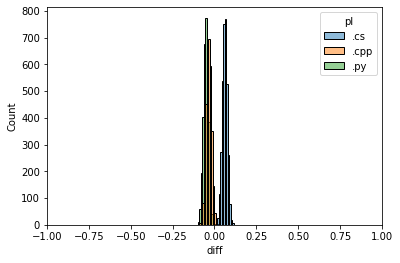

In [29]:
LANGUAGES = ['.py', '.cpp', '.cs']
records_diffs = []

# set the seed
np.random.seed(42)
N_REPETITIONS = 10000

for i in tqdm(range(N_REPETITIONS)):

    # CREATE THE SAME-PL GROUP
    # pick a random langauge
    random_lang = np.random.choice(LANGUAGES)
    #print(f"Random language: {random_lang}")
    df_pl_group = df[df["source_code"].str.endswith(random_lang)]
    #print(f"Number of tasks in the PL group: {len(df_pl_group)}")
    # pick a random subset of tasks
    df_pl_group = df_pl_group.sample(n=N_TASKS_PER_GROUP, replace=True)

    # CREATE THE RANDOM-PL GROUP
    df_random_group = df.sample(n=N_TASKS_PER_GROUP, replace=True)

    # COMPUTE THE DIFFERENCE BETWEEN THE AVERAGE OF TE TWO GROUPS
    avg_pl_group = df_pl_group["correlation"].mean()
    avg_random_group = df_random_group["correlation"].mean()
    diff = avg_pl_group - avg_random_group

    # STORE THE DIFFERENCE
    records_diffs.append({
        "diff": diff,
        "avg_pl_group": avg_pl_group,
        "avg_random_group": avg_random_group,
        "pl": random_lang,
        "type": 'pl'
    })

    # CREATE ANOTHER RANDOM-PL GROUP
    df_random_group_bis = df.sample(n=N_TASKS_PER_GROUP, replace=True)
    avg_random_group_bis = df_random_group_bis["correlation"].mean()
    records_diffs.append({
        "diff": diff,
        "avg_random_group": avg_random_group,
        "avg_random_group_bis": avg_random_group_bis,
        "type": 'random'
    })

df_results = pd.DataFrame.from_records(records_diffs)
df_results_diff_pl = df_results[df_results["type"] == 'pl']
df_results_diff_random = df_results[df_results["type"] == 'random']

# PLOT THE DISTRIBUTION OF THE DIFFERENCES
sns.histplot(
    data=df_results_diff_pl,
    x="diff",
    hue="pl",
)
plt.xlim(-1, 1)

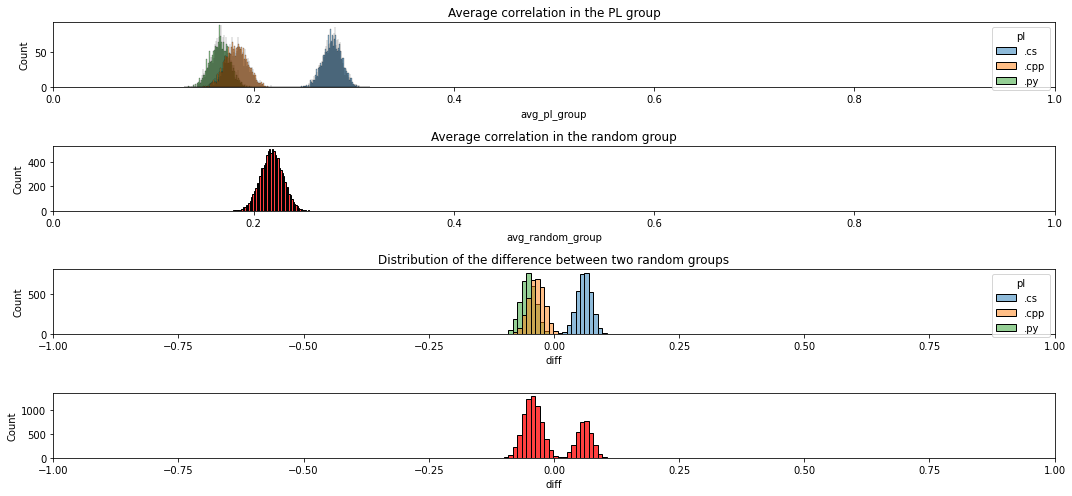

In [38]:
# PLOT THE DISTRIBUTION OF THE DIFFERENCES
fig, axes = plt.subplots(4, 1, figsize=(15, 7))
ax_pl = axes[0]
ax_random = axes[1]
ax_diff = axes[2]
ax_diff_random_groups = axes[3]

sns.histplot(
    data=df_results_diff_pl,
    x="avg_pl_group",
    hue="pl",
    binwidth=0.0005,
    ax=ax_pl
)
ax_pl.set_xlim(0, 1)
ax_pl.set_title("Average correlation in the PL group")

sns.histplot(
    data=df_results_diff_pl,
    x="avg_random_group",
    ax=ax_random,
    color="red"
)
ax_random.set_xlim(0, 1)
ax_random.set_title("Average correlation in the random group")

sns.histplot(
    data=df_results_diff_pl,
    x="diff",
    hue="pl",
    ax=ax_diff,
)
ax_diff.set_xlim(-1, 1)
ax_diff.set_title("Distribution of the difference between a PL group and a random group")

sns.histplot(
    data=df_results_diff_random,
    x="diff",
    ax=ax_diff_random_groups,
    color="red"
)
ax_diff_random_groups.set_xlim(-1, 1)
ax_diff.set_title("Distribution of the difference between two random groups")

plt.tight_layout()

In [35]:
# Check if the mean of each PL group is significantly different from the mean of the random group

from scipy.stats import ttest_ind

def test_mean(data_1, data_2):
    """Run the t-test to see if the two means are significantly different."""
    stat, p = ttest_ind(data_1, data_2)
    print('stat=%.3f, p=%.3f' % (stat, p))
    if p > 0.05:
        print('Probably the same distribution')
    else:
        print('Probably different distributions')

PAIRS = [
    ['.py', '.cpp'],
    ['.py', '.cs'],
    ['.cpp', '.cs'],
]

for pair in PAIRS:
    pl_1, pl_2 = pair
    print("=" * 80)
    print(f"Testing avg correaltion of {pl_1} vs {pl_2} groups")
    data_1 = df_results_diff_pl[df_results_diff_pl["pl"] == pl_1]["avg_pl_group"]
    data_2 = df_results_diff_pl[df_results_diff_pl["pl"] == pl_2]["avg_pl_group"]
    test_mean(data_1, data_2)


Testing avg correaltion of .py vs .cpp groups
stat=-62.630, p=0.000
Probably different distributions
Testing avg correaltion of .py vs .cs groups
stat=-464.599, p=0.000
Probably different distributions
Testing avg correaltion of .cpp vs .cs groups
stat=-372.287, p=0.000
Probably different distributions
